# SpatioTemporal BLIS-Net Adaptation - PEMS-BAY Dataset
Run the cells in this notebook to train and evaluate the STBLIS-Net. 
First, import the necessary libraries.

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stblis_utils as stb
from stblis_classes import STBLISPrecompute, MLPNet
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

### Load the train, test, and val data
Shape is (num_samples, num_sensors, num_timesteps)

In [2]:
# Define the path to the compressed training data file
train_file_path = 'data/PEMS-BAY/train.npz'

# Load the data for training
with np.load(train_file_path) as data:
    # Convert to float32 and permute dimensions (0, 2, 1, 3)
    x_train = torch.from_numpy(data['x']).permute(0, 2, 1, 3).to(torch.float32)
    y_train = torch.from_numpy(data['y']).permute(0, 2, 1, 3).to(torch.float32)  # Apply permute to y_train as well

x_train = x_train[..., 0]
y_train = y_train[..., 0]
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

# Define the path to the compressed test data file
test_file_path = 'data/PEMS-BAY/test.npz'

# Load the data for testing
with np.load(test_file_path) as data:
    x_test = torch.from_numpy(data['x']).permute(0, 2, 1, 3).to(torch.float32)  # Permuting dimensions for x_test
    y_test = torch.from_numpy(data['y']).permute(0, 2, 1, 3).to(torch.float32)  # Apply permute to y_test as well

x_test= x_test[..., 0]
y_test = y_test[..., 0]
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

# Define the path to the compressed validation data file
val_file_path = 'data/PEMS-BAY/val.npz'

# Load the data for validation
with np.load(val_file_path) as data:
    x_val = torch.from_numpy(data['x']).permute(0, 2, 1, 3).to(torch.float32)  # Permuting dimensions for x_val
    y_val = torch.from_numpy(data['y']).permute(0, 2, 1, 3).to(torch.float32)  # Apply permute to y_val as well

x_val = x_val[..., 0]
y_val = y_val[..., 0]
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

x_train shape: torch.Size([36465, 325, 12])
y_train shape: torch.Size([36465, 325, 12])
x_test shape: torch.Size([10419, 325, 12])
y_test shape: torch.Size([10419, 325, 12])
x_val shape: torch.Size([5209, 325, 12])
y_val shape: torch.Size([5209, 325, 12])


### Load the adjacency matrix and create the time adjacency matrix. Create dictionaries for the mean and standard deviation values of each sensor, which can be used later to plot the original data.
Spatial adjacency matrix has shape (num_sensors, num_sensors).

Temporal adjacency matrix has shape (num_timesteps, num_timesteps).

In [3]:
# File paths
adj_file = 'adj_mx_bay.pkl'
data_file = "data/PEMS-BAY/pems-bay.h5"

# Load adjacency matrix data from pickle file
with open(adj_file, 'rb') as f:
    sensor_ids, sensor_id_to_ind, adj_mx = pickle.load(f, encoding='latin1')

# Convert adjacency matrix to a tensor and set its dtype to float32
adj_mx = torch.from_numpy(adj_mx).to(torch.float32)
print(f"Spatial adjacency Matrix Shape: {adj_mx.shape}")

# Generate time adjacency matrix
tadj_mx = stb.get_time_adj(x_train.shape[2])
print(f"Temporal Adjacency Matrix Shape: {tadj_mx.shape}")

# Load dataset
df = pd.read_hdf(data_file)

# Compute mean and standard deviation for each sensor, store in dict
mean_values = df.mean().to_dict()
std_values = df.std().to_dict()

# Map mean and std values to the corresponding sensor indices
mean_ind_dict = {
    sensor_id_to_ind[sensor_id]: mean_values[sensor_id]
    for sensor_id in mean_values if sensor_id in sensor_id_to_ind
}

std_ind_dict = {
    sensor_id_to_ind[sensor_id]: std_values[sensor_id]
    for sensor_id in std_values if sensor_id in sensor_id_to_ind
}

Spatial adjacency Matrix Shape: torch.Size([325, 325])
Temporal Adjacency Matrix Shape: torch.Size([12, 12])


### Set model hyperparameters

In [4]:
# BLIS module parameters
# K specifies the number of spatial wavelet filters in the frame. Total spatial filters = K+2
# J specifies the number of temporal wavelet filters in the frame. Total temporal filters = J+2
K = 4
J = 2

# MLP Parameters
_, num_nodes, num_timesteps = x_train.shape
mlp_input_dim = num_nodes * num_timesteps
embedding_dim = int(mlp_input_dim / 4)
output_dim = 12

# Training parameters
batch_size = 64
num_epochs = 50
patience, trigger_times = 10, 0  # Patience of 10 epochs
learning_rate = 0.001
num_trainings = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device detected: {device}")

Device detected: cuda


### Precompute STBLIS module
This does not need to be done over each training iteration because it is deterministic. Thus, we save the precomputed outputs for later.

In [5]:
# Instantiate model
blis_precomp = STBLISPrecompute(adj_mx, tadj_mx, K, J)

with torch.no_grad():
    print("Precomputing Train!")
    precomputed_train = blis_precomp(x_train)
    print("Precomputing Val!")
    precomputed_val = blis_precomp(x_val)
    print("Precomputing Test!")
    precomputed_test = blis_precomp(x_test)

# Save precomputed tensors
torch.save(precomputed_train, 'precomputed_train_bay.pt')
torch.save(precomputed_val, 'precomputed_val_bay.pt')
torch.save(precomputed_test, 'precomputed_test_bay.pt')

Precomputing Train!
Precomputing Val!
Precomputing Test!


### Load precomputed data

In [6]:
precomputed_train = torch.load('precomputed_train_bay.pt')
precomputed_val = torch.load('precomputed_val_bay.pt')
precomputed_test = torch.load('precomputed_test_bay.pt')

# Create new DataLoaders for precomputed data
precomputed_train_loader = DataLoader(TensorDataset(precomputed_train, y_train), batch_size=batch_size, shuffle=True)
precomputed_val_loader = DataLoader(TensorDataset(precomputed_val, y_val), batch_size=batch_size, shuffle=False)
precomputed_test_loader = DataLoader(TensorDataset(precomputed_test, y_test), batch_size=batch_size, shuffle=False)

### Train the model multiple times

In [7]:
for train_iter in range(num_trainings):
    print(f"\n\nTRAINING MODEL {train_iter+1}\n\n")
        
    # Define model save name
    model_save_name = f'best_STBLIS_bay_model_{train_iter+1}.pth'
    
    # Define a new model for each training iteration
    mlp_model = MLPNet(mlp_input_dim, embedding_dim, output_dim, num_nodes, device).to(device)
                                                                                      
    # Wrap model with DataParallel to utilize all GPU resources
    if torch.cuda.device_count() > 1:
        mlp_model = nn.DataParallel(mlp_model)
    
    # Defien loss function and optimizer
    criterion = nn.L1Loss()
    optimizer = optim.Adam(mlp_model.parameters(), lr=learning_rate)
    
    best_val_loss = float('inf')
    
    # Training loop
    for epoch in range(num_epochs):
        mlp_model.train()
        train_loss = 0.0
        
        for x_batch, y_batch in tqdm(precomputed_train_loader, desc=f"Train Epoch {epoch + 1}"):
            x_b, y_b = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            # Pad batch with zeros on last batch
            A, B, C = x_b.shape
            if A != batch_size:
                x_b = stb.pad_tensor(x_b, batch_size)
                y_b = stb.pad_tensor(y_b, batch_size)
                A, B, C = x_b.shape
                        
            x_b = x_b.reshape(A, B*C)
            
            output = mlp_model(x_b)
            loss = criterion(output, y_b)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x_b.size(0)
        
        train_loss /= len(precomputed_train_loader.dataset)
    
        # Validation loop
        mlp_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x_val_batch, y_val_batch in tqdm(precomputed_val_loader, desc=f"Validation Epoch {epoch + 1}"):
                x_b, y_b = x_val_batch.to(device), y_val_batch.to(device)

                # Pad batch with zeros on last batch
                A, B, C = x_b.shape
                if A != batch_size:
                    x_b = stb.pad_tensor(x_b, batch_size)
                    y_b = stb.pad_tensor(y_b, batch_size)
                    A, B, C = x_b.shape
                    
                x_b = x_b.reshape(A, B*C)
                
                output = mlp_model(x_b)
                loss = criterion(output, y_b)
                val_loss += loss.item() * x_b.size(0)
        
        val_loss /= len(precomputed_val_loader.dataset)
    
        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
            torch.save(mlp_model.state_dict(), model_save_name)
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f'Model {train_iter+1}: Early stopping!')
                break
    
        print(f'Model {train_iter+1}: Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')



TRAINING MODEL 1




Validation Epoch 1: 100%|██████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 274.59it/s]


Model 1: Epoch 1/50, Train Loss: 0.3777, Validation Loss: 0.3244


Validation Epoch 2: 100%|██████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 283.47it/s]


Model 1: Epoch 2/50, Train Loss: 0.3164, Validation Loss: 0.3122


Validation Epoch 3: 100%|██████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 287.41it/s]


Model 1: Epoch 3/50, Train Loss: 0.3011, Validation Loss: 0.3014


Validation Epoch 4: 100%|██████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 273.22it/s]


Model 1: Epoch 4/50, Train Loss: 0.2919, Validation Loss: 0.3019


Validation Epoch 5: 100%|██████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 290.43it/s]


Model 1: Epoch 5/50, Train Loss: 0.2865, Validation Loss: 0.3201


Validation Epoch 6: 100%|██████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 291.59it/s]


Model 1: Epoch 6/50, Train Loss: 0.2821, Validation Loss: 0.3018


Validation Epoch 7: 100%|██████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 277.27it/s]


Model 1: Epoch 7/50, Train Loss: 0.2786, Validation Loss: 0.2967


Validation Epoch 8: 100%|██████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 286.20it/s]


Model 1: Epoch 8/50, Train Loss: 0.2758, Validation Loss: 0.3091


Validation Epoch 9: 100%|██████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 291.86it/s]


Model 1: Epoch 9/50, Train Loss: 0.2743, Validation Loss: 0.3003


Validation Epoch 10: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 290.53it/s]


Model 1: Epoch 10/50, Train Loss: 0.2719, Validation Loss: 0.3163


Validation Epoch 11: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 297.61it/s]


Model 1: Epoch 11/50, Train Loss: 0.2704, Validation Loss: 0.3012


Validation Epoch 12: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 286.20it/s]


Model 1: Epoch 12/50, Train Loss: 0.2687, Validation Loss: 0.3000


Validation Epoch 13: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 286.85it/s]


Model 1: Epoch 13/50, Train Loss: 0.2673, Validation Loss: 0.2955


Validation Epoch 14: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 283.81it/s]


Model 1: Epoch 14/50, Train Loss: 0.2656, Validation Loss: 0.3253


Validation Epoch 15: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 284.20it/s]


Model 1: Epoch 15/50, Train Loss: 0.2644, Validation Loss: 0.2990


Validation Epoch 16: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 280.01it/s]


Model 1: Epoch 16/50, Train Loss: 0.2637, Validation Loss: 0.2977


Validation Epoch 17: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 279.34it/s]


Model 1: Epoch 17/50, Train Loss: 0.2624, Validation Loss: 0.2937


Validation Epoch 18: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 287.31it/s]


Model 1: Epoch 18/50, Train Loss: 0.2617, Validation Loss: 0.2961


Validation Epoch 19: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 285.62it/s]


Model 1: Epoch 19/50, Train Loss: 0.2615, Validation Loss: 0.2972


Validation Epoch 20: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 287.99it/s]


Model 1: Epoch 20/50, Train Loss: 0.2610, Validation Loss: 0.2966


Validation Epoch 21: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 274.41it/s]


Model 1: Epoch 21/50, Train Loss: 0.2604, Validation Loss: 0.2919


Validation Epoch 22: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 282.98it/s]


Model 1: Epoch 22/50, Train Loss: 0.2592, Validation Loss: 0.3063


Validation Epoch 23: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 285.13it/s]


Model 1: Epoch 23/50, Train Loss: 0.2589, Validation Loss: 0.3013


Validation Epoch 24: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 291.25it/s]


Model 1: Epoch 24/50, Train Loss: 0.2576, Validation Loss: 0.3027


Validation Epoch 25: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 287.65it/s]


Model 1: Epoch 25/50, Train Loss: 0.2573, Validation Loss: 0.2949


Validation Epoch 26: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 285.01it/s]


Model 1: Epoch 26/50, Train Loss: 0.2571, Validation Loss: 0.2972


Validation Epoch 27: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 285.72it/s]


Model 1: Epoch 27/50, Train Loss: 0.2565, Validation Loss: 0.2898


Validation Epoch 28: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 275.13it/s]


Model 1: Epoch 28/50, Train Loss: 0.2565, Validation Loss: 0.2986


Validation Epoch 29: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 285.11it/s]


Model 1: Epoch 29/50, Train Loss: 0.2556, Validation Loss: 0.2999


Validation Epoch 30: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 274.73it/s]


Model 1: Epoch 30/50, Train Loss: 0.2557, Validation Loss: 0.2964


Validation Epoch 31: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 290.26it/s]


Model 1: Epoch 31/50, Train Loss: 0.2549, Validation Loss: 0.3005


Validation Epoch 32: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 278.71it/s]


Model 1: Epoch 32/50, Train Loss: 0.2547, Validation Loss: 0.2878


Validation Epoch 33: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 291.30it/s]


Model 1: Epoch 33/50, Train Loss: 0.2550, Validation Loss: 0.2939


Validation Epoch 34: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 281.61it/s]


Model 1: Epoch 34/50, Train Loss: 0.2542, Validation Loss: 0.2978


Validation Epoch 35: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 276.47it/s]


Model 1: Epoch 35/50, Train Loss: 0.2542, Validation Loss: 0.2913


Validation Epoch 36: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 285.66it/s]


Model 1: Epoch 36/50, Train Loss: 0.2536, Validation Loss: 0.2964


Validation Epoch 37: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 289.18it/s]


Model 1: Epoch 37/50, Train Loss: 0.2535, Validation Loss: 0.2969


Validation Epoch 38: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 285.52it/s]


Model 1: Epoch 38/50, Train Loss: 0.2535, Validation Loss: 0.2919


Validation Epoch 39: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 273.75it/s]


Model 1: Epoch 39/50, Train Loss: 0.2528, Validation Loss: 0.2941


Validation Epoch 40: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 285.90it/s]


Model 1: Epoch 40/50, Train Loss: 0.2528, Validation Loss: 0.2935


Validation Epoch 41: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 283.35it/s]


Model 1: Epoch 41/50, Train Loss: 0.2531, Validation Loss: 0.2938


Validation Epoch 42: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 271.58it/s]


Model 1: Early stopping!


TRAINING MODEL 2




Validation Epoch 1: 100%|██████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 276.70it/s]


Model 2: Epoch 1/50, Train Loss: 0.3771, Validation Loss: 0.3203


Validation Epoch 2: 100%|██████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 277.76it/s]


Model 2: Epoch 2/50, Train Loss: 0.3156, Validation Loss: 0.3097


Validation Epoch 3: 100%|██████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 280.71it/s]


Model 2: Epoch 3/50, Train Loss: 0.3010, Validation Loss: 0.3130


Validation Epoch 4: 100%|██████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 288.73it/s]


Model 2: Epoch 4/50, Train Loss: 0.2920, Validation Loss: 0.3092


Validation Epoch 5: 100%|██████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 278.06it/s]


Model 2: Epoch 5/50, Train Loss: 0.2862, Validation Loss: 0.3008


Validation Epoch 6: 100%|██████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 281.04it/s]


Model 2: Epoch 6/50, Train Loss: 0.2828, Validation Loss: 0.3020


Validation Epoch 7: 100%|██████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 281.11it/s]


Model 2: Epoch 7/50, Train Loss: 0.2787, Validation Loss: 0.3151


Validation Epoch 8: 100%|██████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 286.80it/s]


Model 2: Epoch 8/50, Train Loss: 0.2763, Validation Loss: 0.3044


Validation Epoch 9: 100%|██████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 284.16it/s]


Model 2: Epoch 9/50, Train Loss: 0.2744, Validation Loss: 0.3194


Validation Epoch 10: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 271.09it/s]


Model 2: Epoch 10/50, Train Loss: 0.2716, Validation Loss: 0.2970


Validation Epoch 11: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 282.77it/s]


Model 2: Epoch 11/50, Train Loss: 0.2699, Validation Loss: 0.3064


Validation Epoch 12: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 287.10it/s]


Model 2: Epoch 12/50, Train Loss: 0.2682, Validation Loss: 0.3054


Validation Epoch 13: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 288.15it/s]


Model 2: Epoch 13/50, Train Loss: 0.2677, Validation Loss: 0.2970


Validation Epoch 14: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 286.94it/s]


Model 2: Epoch 14/50, Train Loss: 0.2666, Validation Loss: 0.3027


Validation Epoch 15: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 274.85it/s]


Model 2: Epoch 15/50, Train Loss: 0.2653, Validation Loss: 0.2994


Validation Epoch 16: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 283.94it/s]


Model 2: Epoch 16/50, Train Loss: 0.2637, Validation Loss: 0.2994


Validation Epoch 17: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 270.45it/s]


Model 2: Epoch 17/50, Train Loss: 0.2629, Validation Loss: 0.2933


Validation Epoch 18: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 274.21it/s]


Model 2: Epoch 18/50, Train Loss: 0.2622, Validation Loss: 0.2934


Validation Epoch 19: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 276.20it/s]


Model 2: Epoch 19/50, Train Loss: 0.2618, Validation Loss: 0.3039


Validation Epoch 20: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 282.38it/s]


Model 2: Epoch 20/50, Train Loss: 0.2610, Validation Loss: 0.2975


Validation Epoch 21: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 284.93it/s]


Model 2: Epoch 21/50, Train Loss: 0.2605, Validation Loss: 0.3049


Validation Epoch 22: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 290.80it/s]


Model 2: Epoch 22/50, Train Loss: 0.2610, Validation Loss: 0.3025


Validation Epoch 23: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 285.55it/s]


Model 2: Epoch 23/50, Train Loss: 0.2584, Validation Loss: 0.2923


Validation Epoch 24: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 283.84it/s]


Model 2: Epoch 24/50, Train Loss: 0.2584, Validation Loss: 0.2964


Validation Epoch 25: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 286.51it/s]


Model 2: Epoch 25/50, Train Loss: 0.2582, Validation Loss: 0.2940


Validation Epoch 26: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 279.57it/s]


Model 2: Epoch 26/50, Train Loss: 0.2574, Validation Loss: 0.3000


Validation Epoch 27: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 288.07it/s]


Model 2: Epoch 27/50, Train Loss: 0.2565, Validation Loss: 0.2917


Validation Epoch 28: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 288.16it/s]


Model 2: Epoch 28/50, Train Loss: 0.2566, Validation Loss: 0.2994


Validation Epoch 29: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 278.04it/s]


Model 2: Epoch 29/50, Train Loss: 0.2559, Validation Loss: 0.2967


Validation Epoch 30: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 272.30it/s]


Model 2: Epoch 30/50, Train Loss: 0.2556, Validation Loss: 0.2946


Validation Epoch 31: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 286.98it/s]


Model 2: Epoch 31/50, Train Loss: 0.2553, Validation Loss: 0.2945


Validation Epoch 32: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 278.99it/s]


Model 2: Epoch 32/50, Train Loss: 0.2548, Validation Loss: 0.3004


Validation Epoch 33: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 271.72it/s]


Model 2: Epoch 33/50, Train Loss: 0.2541, Validation Loss: 0.2907


Validation Epoch 34: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 268.33it/s]


Model 2: Epoch 34/50, Train Loss: 0.2544, Validation Loss: 0.2931


Validation Epoch 35: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 284.32it/s]


Model 2: Epoch 35/50, Train Loss: 0.2540, Validation Loss: 0.2916


Validation Epoch 36: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 289.85it/s]


Model 2: Epoch 36/50, Train Loss: 0.2535, Validation Loss: 0.2902


Validation Epoch 37: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 277.05it/s]


Model 2: Epoch 37/50, Train Loss: 0.2532, Validation Loss: 0.2895


Validation Epoch 38: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 283.07it/s]


Model 2: Epoch 38/50, Train Loss: 0.2535, Validation Loss: 0.2959


Validation Epoch 39: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 277.30it/s]


Model 2: Epoch 39/50, Train Loss: 0.2524, Validation Loss: 0.2931


Validation Epoch 40: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 286.58it/s]


Model 2: Epoch 40/50, Train Loss: 0.2523, Validation Loss: 0.3020


Validation Epoch 41: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 284.56it/s]


Model 2: Epoch 41/50, Train Loss: 0.2518, Validation Loss: 0.2917


Validation Epoch 42: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 290.92it/s]


Model 2: Epoch 42/50, Train Loss: 0.2517, Validation Loss: 0.2959


Validation Epoch 43: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 282.87it/s]


Model 2: Epoch 43/50, Train Loss: 0.2519, Validation Loss: 0.3034


Validation Epoch 44: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 283.17it/s]


Model 2: Epoch 44/50, Train Loss: 0.2514, Validation Loss: 0.2959


Validation Epoch 45: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 282.56it/s]


Model 2: Epoch 45/50, Train Loss: 0.2509, Validation Loss: 0.2904


Validation Epoch 46: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 287.60it/s]


Model 2: Epoch 46/50, Train Loss: 0.2508, Validation Loss: 0.2961


Validation Epoch 47: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 281.48it/s]


Model 2: Early stopping!


TRAINING MODEL 3




Validation Epoch 1: 100%|██████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 281.33it/s]


Model 3: Epoch 1/50, Train Loss: 0.3770, Validation Loss: 0.3195


Validation Epoch 2: 100%|██████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 280.21it/s]


Model 3: Epoch 2/50, Train Loss: 0.3159, Validation Loss: 0.3054


Validation Epoch 3: 100%|██████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 285.47it/s]


Model 3: Epoch 3/50, Train Loss: 0.3006, Validation Loss: 0.3066


Validation Epoch 4: 100%|██████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 280.60it/s]


Model 3: Epoch 4/50, Train Loss: 0.2920, Validation Loss: 0.3080


Validation Epoch 5: 100%|██████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 282.11it/s]


Model 3: Epoch 5/50, Train Loss: 0.2875, Validation Loss: 0.3201


Validation Epoch 6: 100%|██████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 275.01it/s]


Model 3: Epoch 6/50, Train Loss: 0.2818, Validation Loss: 0.2966


Validation Epoch 7: 100%|██████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 270.55it/s]


Model 3: Epoch 7/50, Train Loss: 0.2793, Validation Loss: 0.3174


Validation Epoch 8: 100%|██████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 285.96it/s]


Model 3: Epoch 8/50, Train Loss: 0.2758, Validation Loss: 0.2988


Validation Epoch 9: 100%|██████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 279.09it/s]


Model 3: Epoch 9/50, Train Loss: 0.2738, Validation Loss: 0.3131


Validation Epoch 10: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 285.39it/s]


Model 3: Epoch 10/50, Train Loss: 0.2713, Validation Loss: 0.3042


Validation Epoch 11: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 287.68it/s]


Model 3: Epoch 11/50, Train Loss: 0.2700, Validation Loss: 0.2960


Validation Epoch 12: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 287.39it/s]


Model 3: Epoch 12/50, Train Loss: 0.2684, Validation Loss: 0.2940


Validation Epoch 13: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 291.47it/s]


Model 3: Epoch 13/50, Train Loss: 0.2674, Validation Loss: 0.2983


Validation Epoch 14: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 273.63it/s]


Model 3: Epoch 14/50, Train Loss: 0.2654, Validation Loss: 0.2925


Validation Epoch 15: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 284.90it/s]


Model 3: Epoch 15/50, Train Loss: 0.2642, Validation Loss: 0.2955


Validation Epoch 16: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 285.28it/s]


Model 3: Epoch 16/50, Train Loss: 0.2633, Validation Loss: 0.3015


Validation Epoch 17: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 287.28it/s]


Model 3: Epoch 17/50, Train Loss: 0.2630, Validation Loss: 0.2921


Validation Epoch 18: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 287.47it/s]


Model 3: Epoch 18/50, Train Loss: 0.2616, Validation Loss: 0.2922


Validation Epoch 19: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 286.36it/s]


Model 3: Epoch 19/50, Train Loss: 0.2609, Validation Loss: 0.2964


Validation Epoch 20: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 287.58it/s]


Model 3: Epoch 20/50, Train Loss: 0.2615, Validation Loss: 0.2975


Validation Epoch 21: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 282.63it/s]


Model 3: Epoch 21/50, Train Loss: 0.2598, Validation Loss: 0.2950


Validation Epoch 22: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 285.27it/s]


Model 3: Epoch 22/50, Train Loss: 0.2587, Validation Loss: 0.2977


Validation Epoch 23: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 290.19it/s]


Model 3: Epoch 23/50, Train Loss: 0.2589, Validation Loss: 0.2893


Validation Epoch 24: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 286.51it/s]


Model 3: Epoch 24/50, Train Loss: 0.2575, Validation Loss: 0.3020


Validation Epoch 25: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 286.37it/s]


Model 3: Epoch 25/50, Train Loss: 0.2569, Validation Loss: 0.3016


Validation Epoch 26: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 286.07it/s]


Model 3: Epoch 26/50, Train Loss: 0.2572, Validation Loss: 0.2959


Validation Epoch 27: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 276.06it/s]


Model 3: Epoch 27/50, Train Loss: 0.2563, Validation Loss: 0.2950


Validation Epoch 28: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 282.89it/s]


Model 3: Epoch 28/50, Train Loss: 0.2562, Validation Loss: 0.2910


Validation Epoch 29: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 284.29it/s]


Model 3: Epoch 29/50, Train Loss: 0.2554, Validation Loss: 0.2971


Validation Epoch 30: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 289.52it/s]


Model 3: Epoch 30/50, Train Loss: 0.2554, Validation Loss: 0.2909


Validation Epoch 31: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 287.24it/s]


Model 3: Epoch 31/50, Train Loss: 0.2553, Validation Loss: 0.2935


Validation Epoch 32: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 286.64it/s]


Model 3: Epoch 32/50, Train Loss: 0.2548, Validation Loss: 0.3012


Validation Epoch 33: 100%|█████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 285.82it/s]

Model 3: Early stopping!


### Evaluate the trained models
We will generate the predicted outputs and store them in a dictionary, allowing us to plot them later

In [8]:
model_preds_dict = {}
model_actuals_dict = {}
for test_iter in range(num_trainings):

    # Load model for testing
    model_save_name = f'best_STBLIS_bay_model_{test_iter+1}.pth'
    
    # Load the trained model's state dictionary
    state_dict = torch.load(model_save_name)
    
    # Remove 'module.' prefix if present
    state_dict = stb.remove_module_prefix(state_dict)

    # Load model parameters
    mlp_model = MLPNet(mlp_input_dim, embedding_dim, output_dim, num_nodes, device).to(device)
    mlp_model.load_state_dict(state_dict)
    
    # Define loss function and optimizer
    criterion = nn.L1Loss()
    optimizer = optim.Adam(mlp_model.parameters(), lr=learning_rate)
    
    # Testing loop
    mlp_model.eval()
    test_loss = 0.0

    all_test_preds = []
    all_test_actuals = []
    with torch.no_grad():
        for x_batch, y_batch in tqdm(precomputed_test_loader, desc=f"Evaluating on Test Data"):
            x_b, y_b = x_batch.to(device), y_batch.to(device)

            # Pad batch_size on last batch so that it is the same as the other batch sizes
            A, B, C = x_b.shape
            if A != batch_size:
                x_b = stb.pad_tensor(x_b, batch_size)
                y_b = stb.pad_tensor(y_b, batch_size)
                A, B, C = x_b.shape
        
            x_b = x_b.reshape(A, B*C)
            
            output = mlp_model(x_b)
            loss = criterion(output, y_b)
            test_loss += loss.item() * x_b.size(0)
            all_test_preds.append(output.cpu())
            all_test_actuals.append(y_b.cpu())
    
    all_test_preds = torch.cat(all_test_preds, dim=0)
    all_test_actuals = torch.cat(all_test_actuals, dim=0)
    
    test_loss /= len(precomputed_test_loader.dataset)
    print(f'Model {test_iter+1}: Test Loss: {test_loss:.4f}')

    # Save predictions and actuals in a dictionary for easy access later
    model_preds_dict[test_iter+1] = all_test_preds
    model_actuals_dict[test_iter+1] = all_test_actuals

Evaluating on Test Data: 100%|███████████████████████████████████████████████████████| 163/163 [00:00<00:00, 667.07it/s]


Model 1: Test Loss: 0.3065


Evaluating on Test Data: 100%|███████████████████████████████████████████████████████| 163/163 [00:00<00:00, 669.75it/s]


Model 2: Test Loss: 0.3040


Evaluating on Test Data: 100%|███████████████████████████████████████████████████████| 163/163 [00:00<00:00, 571.55it/s]


Model 3: Test Loss: 0.3076


### Generate sample plots of the predicted outputs

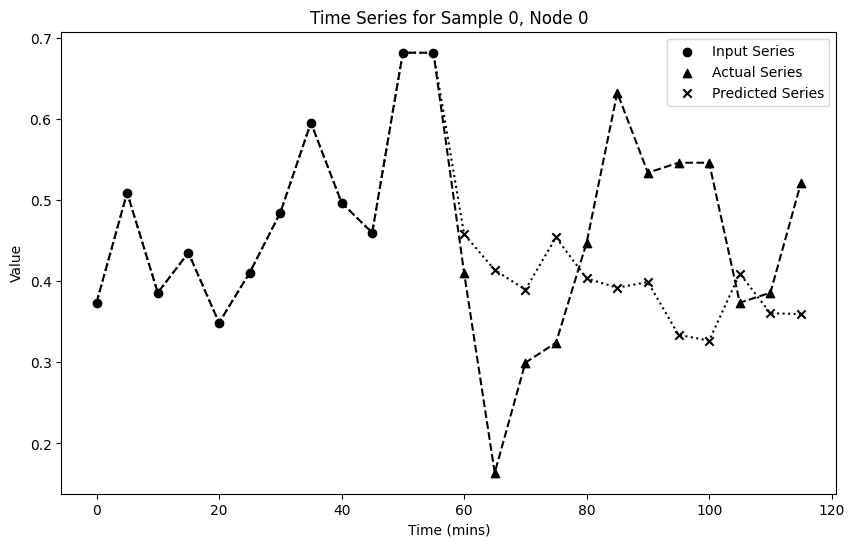

In [12]:
model_num = 1 # Specify the model you want to plot. This is 1-indexed
sample_index = 0  # Specify the sample index you want to plot
node_index = 0 # Specify the node index you want to plot
model_test_preds = model_preds_dict[model_num]
model_test_actuals = model_actuals_dict[model_num]

# Call helper function to plot the predicted vs actual output
stb.plot_time_series(sample_index, node_index, x_test, model_test_actuals, model_test_preds, num_timesteps, num_nodes, output_dim, mean_ind_dict, std_ind_dict, zscore=True)

### Calculate metrics for model evaluation

In [14]:
# Initialize empty dictionaries to hold the sum of metrics and squared sum for std calculation
# Index 2 is 15 mins, index 5 is 30 mins, index 11 is 60 mins (each index is a 5 min interval)
avg_metrics = {}
std_metrics = {}
indices = [2, 5, 11]

# Initialize the dictionaries to accumulate metrics and squared metrics for each index
for idx in indices:
    avg_metrics[idx] = {'MAE': 0, 'RMSE': 0, 'MAPE': 0}
    std_metrics[idx] = {'MAE': 0, 'RMSE': 0, 'MAPE': 0}

# Loop over each training/trial
for model_num in range(num_trainings):
    model_test_preds = model_preds_dict[model_num + 1]
    model_test_actuals = model_actuals_dict[model_num + 1]
    
    # Get metrics for this trial
    metrics = stb.calculate_metrics_per_index(model_test_preds, model_test_actuals, indices)
    
    # Accumulate the metrics and squared metrics for averaging and std calculation
    for idx in metrics:
        for metric in metrics[idx]:
            avg_metrics[idx][metric] += metrics[idx][metric]
            std_metrics[idx][metric] += metrics[idx][metric] ** 2

# Calculate the average and std across all trials
for idx in avg_metrics:
    for metric in avg_metrics[idx]:
        avg_metrics[idx][metric] /= num_trainings
        std_metrics[idx][metric] = np.sqrt(std_metrics[idx][metric] / num_trainings - avg_metrics[idx][metric] ** 2)

# Print the averaged and std metrics for each index
print(f"Average metrics over {num_trainings} training samples:")
for idx in avg_metrics:
    print(f"Time Prediction {(idx + 1) * 5} mins: "
          f"Avg MAE: {avg_metrics[idx]['MAE']:.4f}, "
          f"Avg RMSE: {avg_metrics[idx]['RMSE']:.4f}, "
          f"Avg MAPE: {avg_metrics[idx]['MAPE']:.4f}, "
          f"Std MAE: {std_metrics[idx]['MAE']:.4f}, "
          f"Std RMSE: {std_metrics[idx]['RMSE']:.4f}, "
          f"Std MAPE: {std_metrics[idx]['MAPE']:.4f}")


Average metrics over 3 training samples:
Time Prediction 15 mins: Avg MAE: 0.2976, Avg RMSE: 0.6040, Avg MAPE: 2.1389, Std MAE: 0.0016, Std RMSE: 0.0009, Std MAPE: 0.0303
Time Prediction 30 mins: Avg MAE: 0.3051, Avg RMSE: 0.6217, Avg MAPE: 2.1765, Std MAE: 0.0015, Std RMSE: 0.0015, Std MAPE: 0.0258
Time Prediction 60 mins: Avg MAE: 0.3180, Avg RMSE: 0.6472, Avg MAPE: 2.2328, Std MAE: 0.0018, Std RMSE: 0.0033, Std MAPE: 0.0295
